<a href="https://colab.research.google.com/github/kishusingh413/Weather_Forecasting_using_Uncertanity_Concept/blob/main/TermProject_KM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("precipitation_data.csv",header=1)
data.head()

,Year\,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,annual mean
0,1981,36.91,5.27,10.55,10.55,42.19,63.28,569.53,195.12,184.57,0.00,21.09,10.55,1149.61,95.800833
1,1982,31.64,21.09,36.91,52.73,36.91,147.66,142.38,205.66,94.92,26.37,21.09,0.00,817.38,68.113333
2,1983,0.00,0.00,0.00,5.27,0.00,100.20,163.48,131.84,42.19,47.46,0.00,10.55,500.98,41.749167
3,1984,10.55,36.91,0.00,0.00,0.00,279.49,337.50,274.22,221.48,5.27,0.00,0.00,1165.43,97.118333
4,1985,15.82,0.00,0.00,0.00,5.27,52.73,485.16,290.04,258.40,168.75,0.00,5.27,1281.45,106.786667


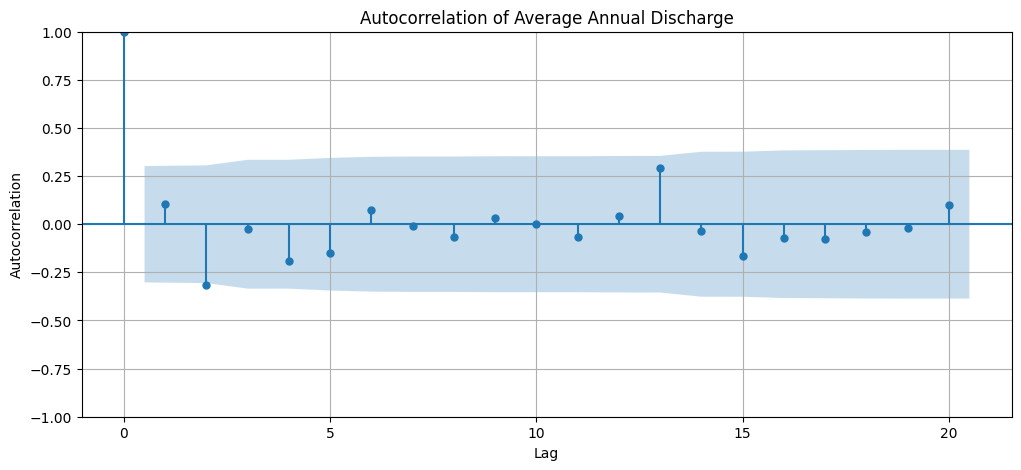

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation for the 'Avg Annual' column
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(data['annual mean'].dropna(), ax=ax, lags=20)
plt.title('Autocorrelation of Average Annual Discharge')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

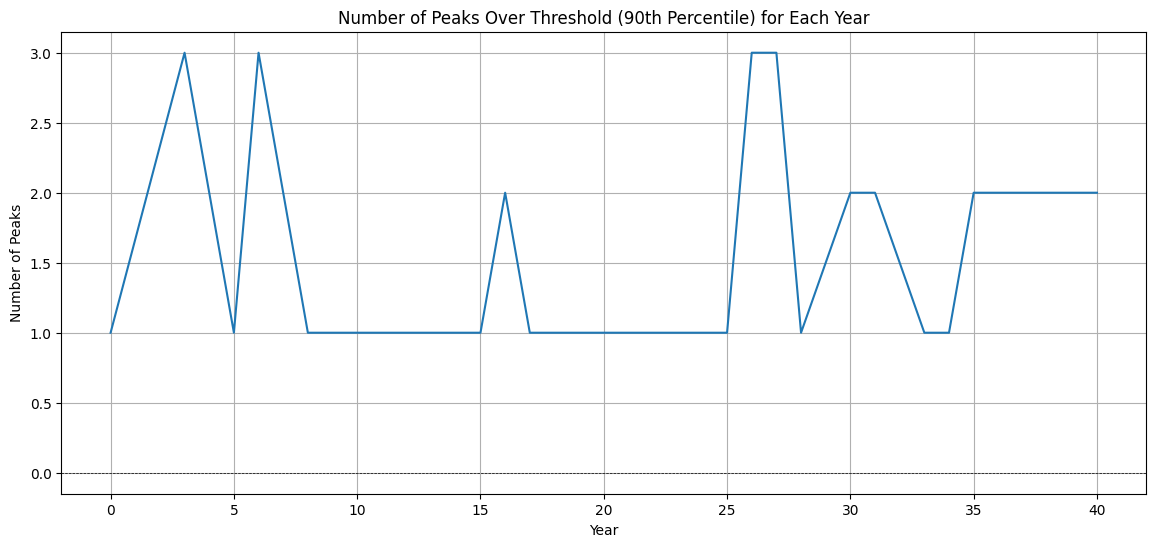

In [ ]:
# Calculate the 90th percentile of the monthly discharge data as the threshold
threshold = data[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].stack().quantile(0.90)

# Identify peaks above the threshold
peaks_above_threshold = data[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].apply(lambda x: x[x > threshold])

# Count the number of peaks above threshold for each year
peaks_count = peaks_above_threshold.count(axis=1)

# Plotting the number of peaks above the threshold for each year
plt.figure(figsize=(14, 6))
peaks_count.plot()
plt.axhline(y=0, color='black', linestyle='--', lw=0.5)
plt.title('Number of Peaks Over Threshold (90th Percentile) for Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Peaks')
plt.grid(True)
plt.show()

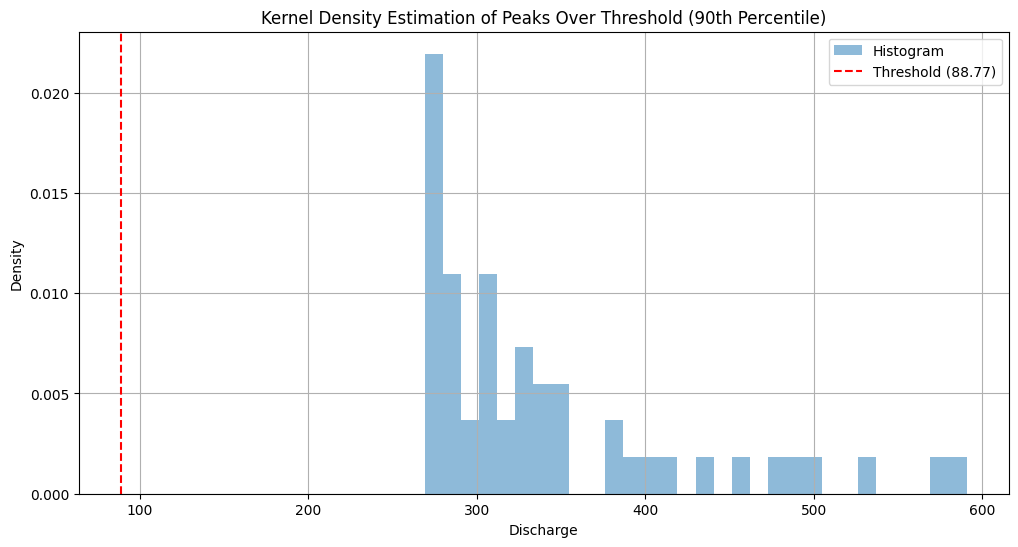

In [ ]:
# Extracting the values of peaks above the threshold
peaks_values = peaks_above_threshold.stack().values

# Kernel Density Estimation (KDE) for peaks above the threshold
plt.figure(figsize=(12, 6))
plt.hist(peaks_values, bins=30, density=True, alpha=0.5, label='Histogram')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title('Kernel Density Estimation of Peaks Over Threshold (90th Percentile)')
plt.xlabel('Discharge')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate the 90th percentile of the average annual discharge
threshold = data["annual mean"].quantile(0.90)

# Extract all values above this threshold as peaks
peaks = data[data["annual mean"] > threshold]["annual mean"]

peaks

4     106.786667
6     114.697500
26    111.182500
27    128.759167
40    112.046667
Name: annual mean, dtype: float64

In [ ]:
from scipy.stats import kstest
from sklearn.neighbors import KernelDensity
import numpy as np

# Fitting a KDE to the POT series
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(peaks.values.reshape(-1, 1))

# Generating a sample from the KDE
sample = kde.sample(1000)  # Generating a sample of size 1000

# Performing the KS test
ks_statistic, ks_p_value = kstest(peaks, lambda x: np.exp(kde.score_samples(x.reshape(-1, 1))))

ks_statistic, ks_p_value

(0.8936153918929512, 2.725360681650868e-05)

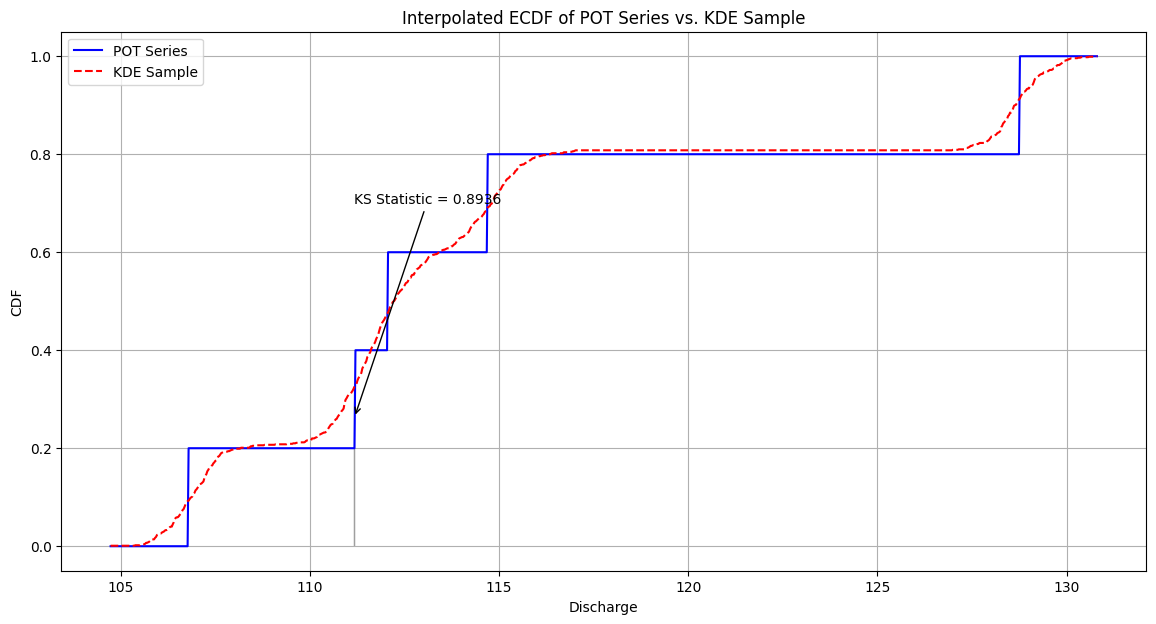

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

# Getting the ECDF of the POT series
ecdf_pot = ECDF(peaks)

# Getting the ECDF of the KDE sample
ecdf_sample = ECDF(sample.flatten())

# Interpolating the ECDFs over a common range
x_common = np.linspace(min(peaks.min(), sample.min()), max(peaks.max(), sample.max()), 1000)
y_pot = ecdf_pot(x_common)
y_sample = ecdf_sample(x_common)

# Plotting the interpolated ECDFs
plt.figure(figsize=(14, 7))
plt.plot(x_common, y_pot, label="POT Series", color='blue', linestyle='-')
plt.plot(x_common, y_sample, label="KDE Sample", color='red', linestyle='--')

# Highlighting the KS statistic
max_diff_index = np.argmax(np.abs(y_pot - y_sample))
plt.fill_between([x_common[max_diff_index]], 0, [y_pot[max_diff_index]], color='gray', alpha=0.5)
plt.fill_between([x_common[max_diff_index]], 0, [y_sample[max_diff_index]], color='gray', alpha=0.5)
plt.annotate(f'KS Statistic = {ks_statistic:.4f}', xy=(x_common[max_diff_index], 0.5*(y_pot[max_diff_index] + y_sample[max_diff_index])),
             xytext=(x_common[max_diff_index], 0.7), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title("Interpolated ECDF of POT Series vs. KDE Sample")
plt.xlabel("Discharge")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()

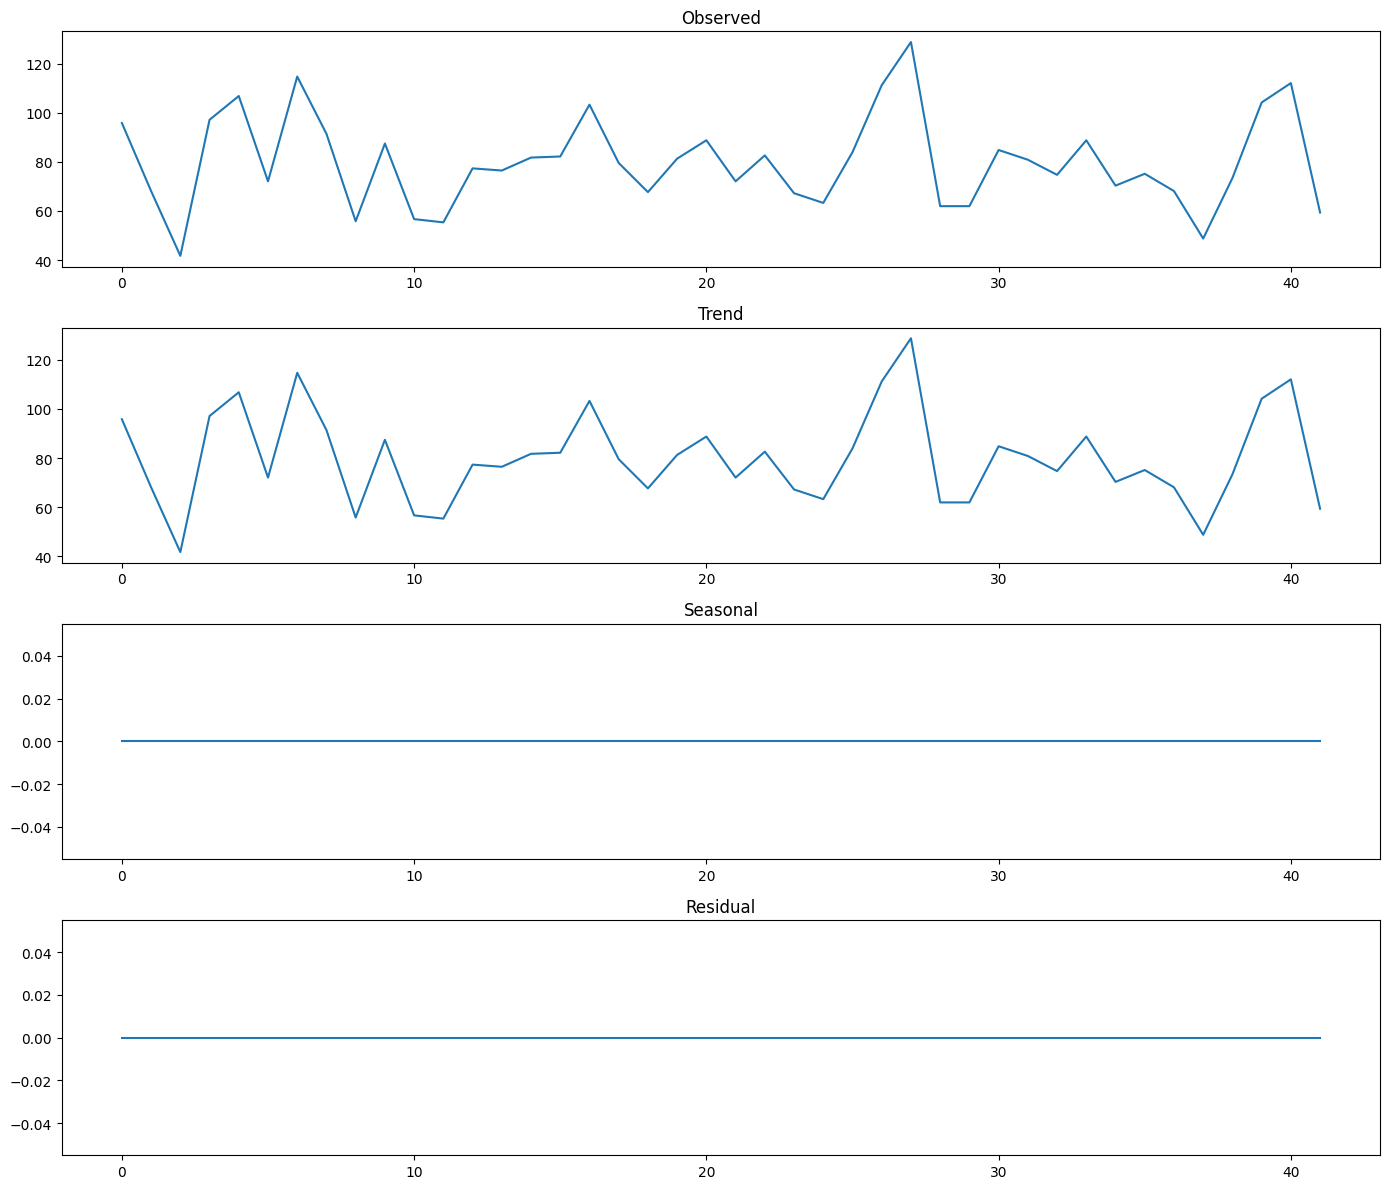

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'Avg Annual' time series
result = seasonal_decompose(data['annual mean'].dropna(), model='additive', period=1)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

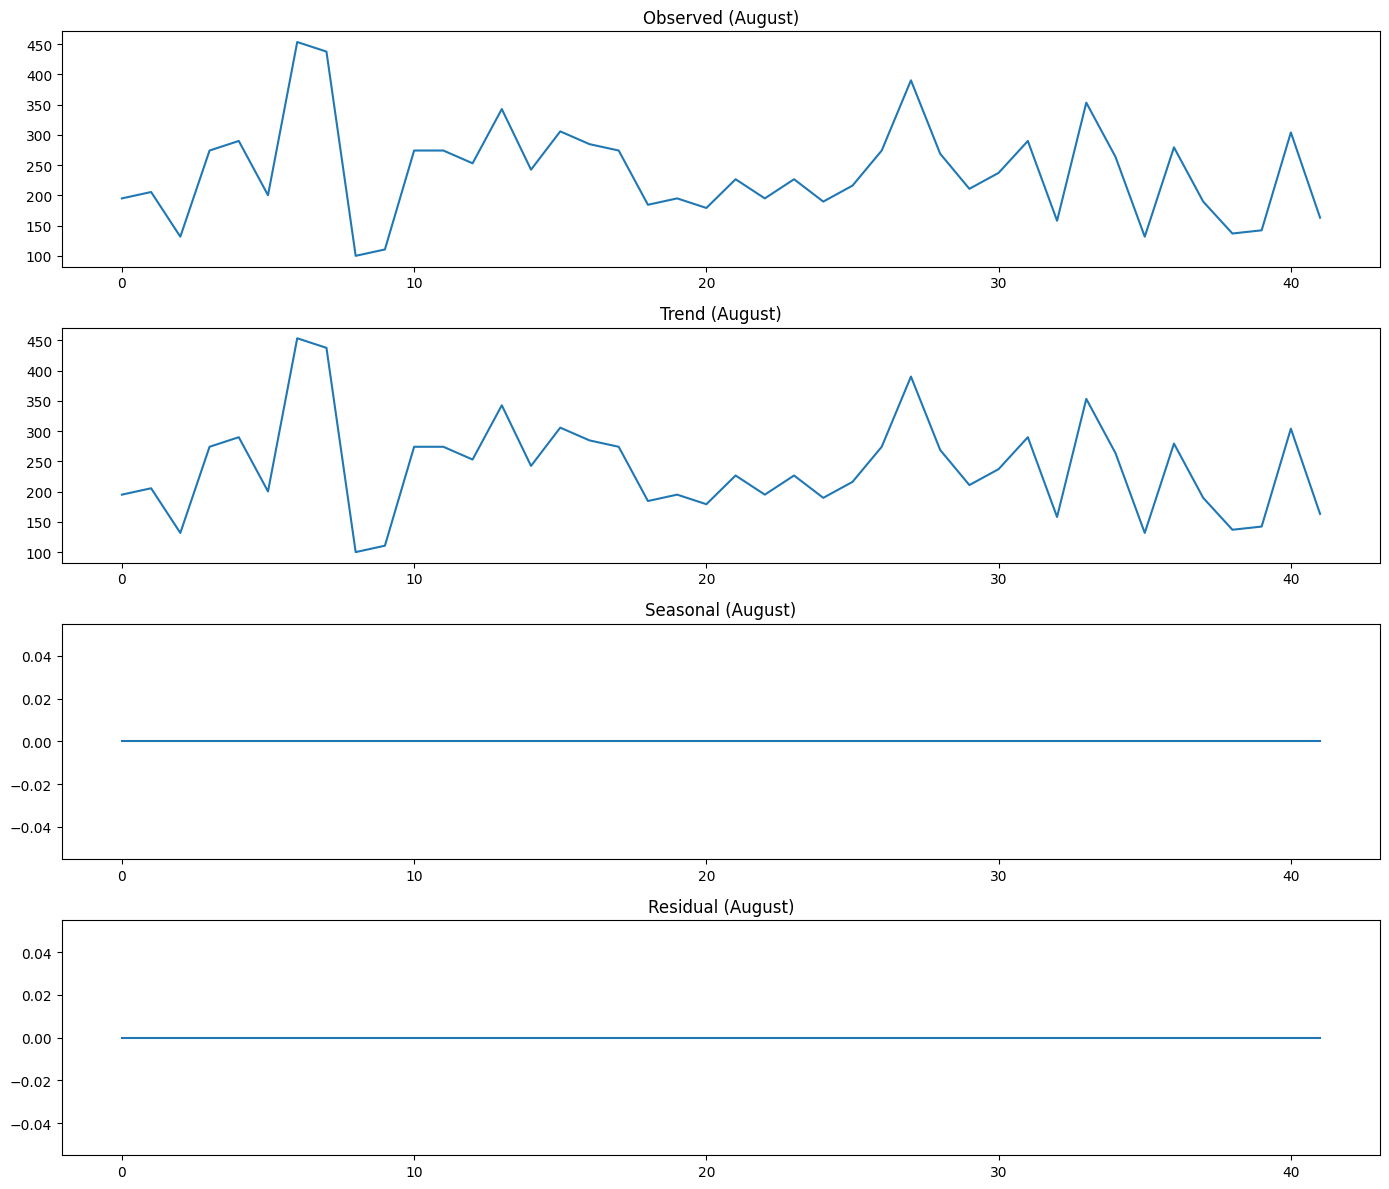

In [ ]:
# Decompose the 'Aug' column to capture intra-year seasonality
result_aug = seasonal_decompose(data['AUG'].dropna(), model='additive', period=1)

# Plot the decomposed components for July
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
result_aug.observed.plot(ax=ax1, title='Observed (August)')
result_aug.trend.plot(ax=ax2, title='Trend (August)')
result_aug.seasonal.plot(ax=ax3, title='Seasonal (August)')
result_aug.resid.plot(ax=ax4, title='Residual (August)')
plt.tight_layout()
plt.show()

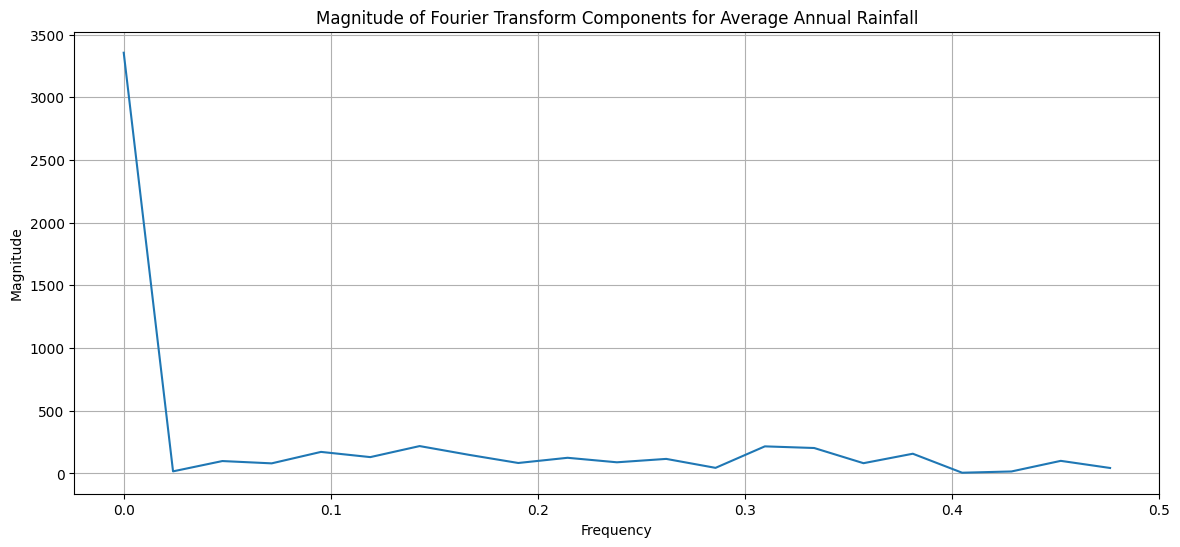

In [ ]:
import numpy as np

# Calculate the Fourier Transform of the 'annual mean' column
frequencies = np.fft.fftfreq(len(data['annual mean'].dropna()))
fourier_values = np.fft.fft(data['annual mean'].dropna())

# Plot the magnitude of the Fourier Transform components
plt.figure(figsize=(14, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fourier_values)[:len(frequencies)//2])
plt.title('Magnitude of Fourier Transform Components for Average Annual Rainfall')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result_adf = adfuller(data['annual mean'].dropna())

# Display the results
adf_statistic = result_adf[0]
adf_pvalue = result_adf[1]
adf_statistic, adf_pvalue

(-5.87438812737254, 3.1847241543738345e-07)

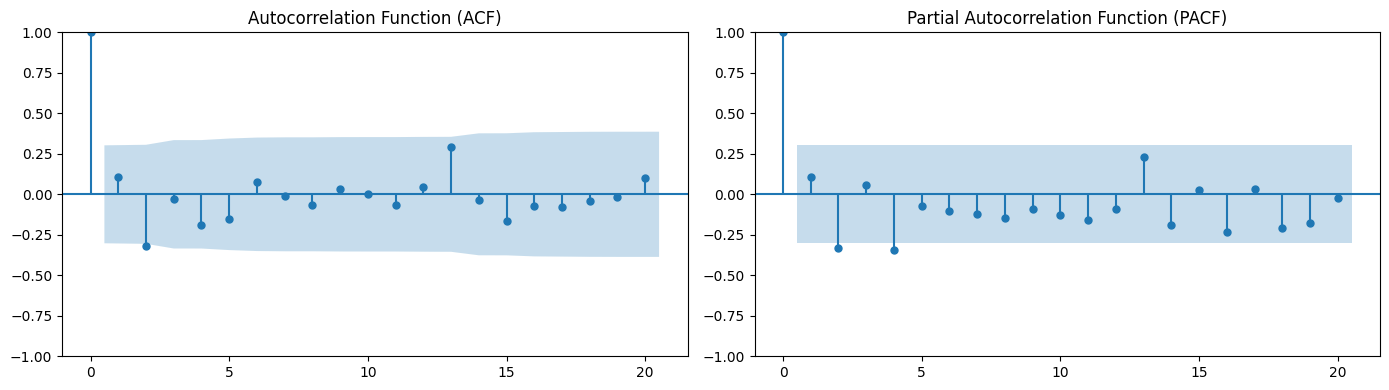

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# ACF plot
plot_acf(data['annual mean'].dropna(), ax=ax[0], lags=20)
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['annual mean'].dropna(), ax=ax[1], lags=20)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, d and q triplets
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

# Generate all different combinations of seasonal p, d and q triplets (using a yearly seasonality of 1)
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p, d, q))]

# Store AIC values
aic_values = []

# Search for the optimal set of parameters that yields the best performance
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data['Avg Annual'].dropna(),
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()
            aic_values.append((param, param_seasonal, results.aic))
        except:
            continue

# # Find the parameters with minimal AIC value
min_aic = min(aic_values, key=lambda x: x[2])

min_aic

In [ ]:
# Generate all different combinations of p and q pairs (as d=0)
pq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]

# Store AIC values
aic_values = []

# Search for the optimal set of parameters that yields the best performance
for param in pq:
    try:
        mod = SARIMAX(data['annual mean'].dropna(),
                      order=param,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

        results = mod.fit()
        aic_values.append((param, results.aic))
    except:
        continue

# Find the parameters with minimal AIC value
min_aic = min(aic_values, key=lambda x: x[1])

min_aic

ValueError: ignored

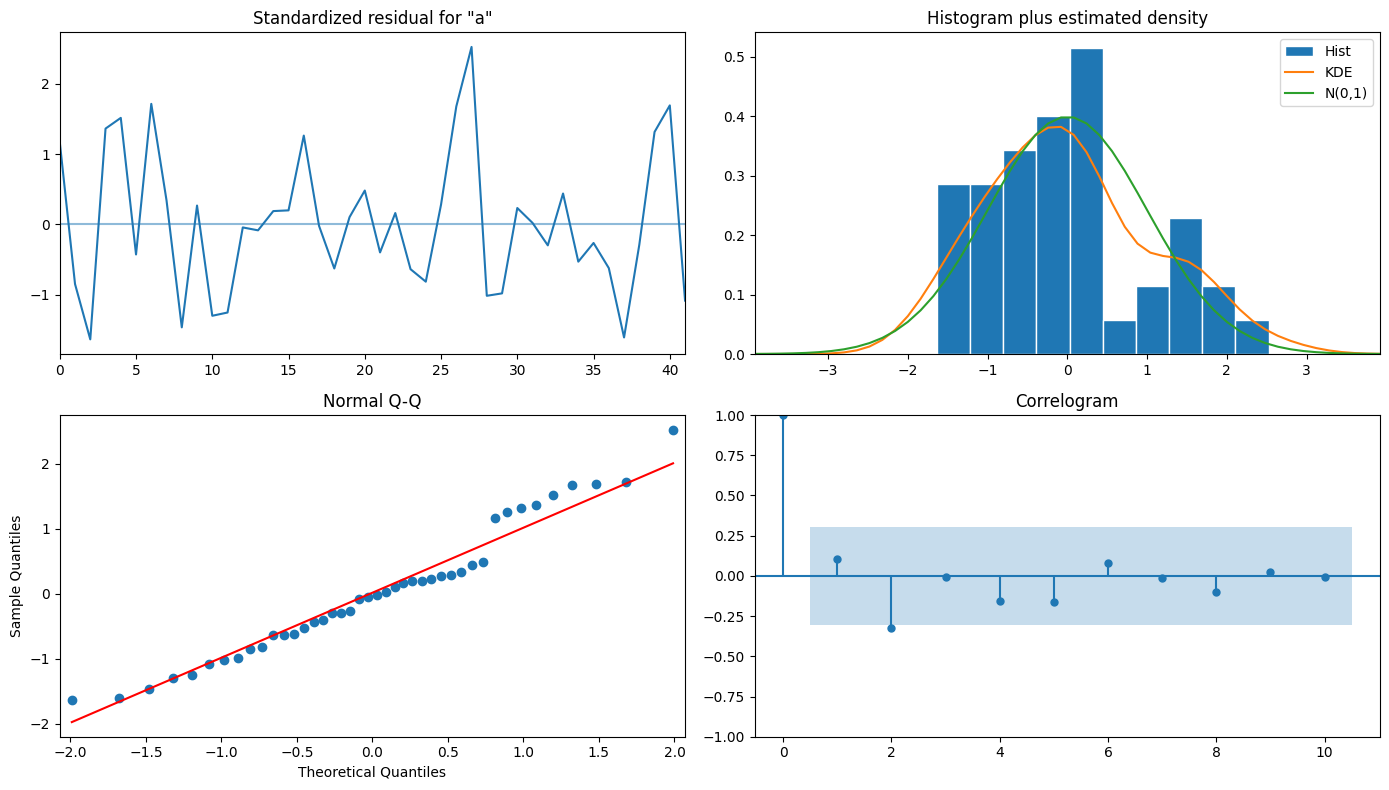

In [ ]:
# Fit the ARIMA(1, 0, 1) model
model = SARIMAX(data['annual mean'].dropna(), order=(1, 0, 1))
results = model.fit()

# Plot the model diagnostics
diagnostics_fig = results.plot_diagnostics(figsize=(14, 8))
plt.tight_layout()
plt.show()

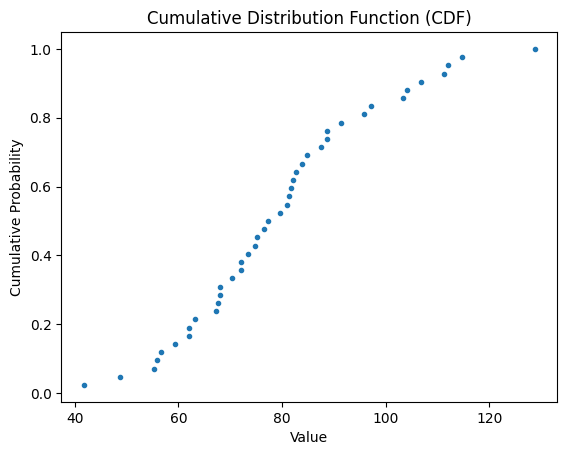

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the CDF
mean_data = data['annual mean']
sorted_data = np.sort(mean_data)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Create a CDF plot
plt.plot(sorted_data, cdf, marker='.', linestyle='none')
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF)")

plt.show()


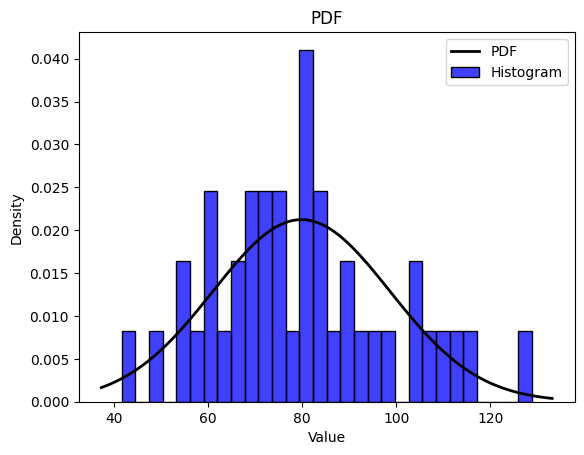

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# Create a histogram
sns.histplot(mean_data, kde=False, stat="density", color='blue', bins=30, label="Histogram")

# Create a PDF using a theoretical distribution (e.g., normal distribution)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(mean_data), np.std(mean_data))
plt.plot(x, p, 'k', linewidth=2, label="PDF")

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("PDF")
plt.legend()
plt.show()
